In [1]:
import pandas as pd
from pyalex import Works, Authors, Sources, Institutions, Concepts, Publishers, Funders
from tqdm import tqdm
from typing import List, Dict
import json
from joblib import delayed, Parallel
import itertools
from itertools import chain
import pickle as pkl

In [2]:
df_results_from_query = pd.DataFrame(pkl.load(open("results_with_names_doi_relationship.pkl", "rb")))
df_results_from_query.iloc[1518] #["title"]

project_id                                                      96/05497-3
orcids                   [https://orcid.org/0000-0001-5203-4366, https:...
title                                        Pesquisa em visão cibernética
summary                  O presente projeto visa suportar as atividades...
keywords                 [Inteligência artificial, Visão computacional,...
related_dois                                                            []
pubs_names               [Optimized approach to multiscale skeleton gen...
name_doi_relationship    {'Optimized approach to multiscale skeleton ge...
Name: 1518, dtype: object

In [3]:
df_results_from_query

,project_id,orcids,title,summary,keywords,related_dois,pubs_names,name_doi_relationship
0,23/00812-7,"[https://orcid.org/0000-0002-9144-7187, https:...",Aceleração de aplicações sensíveis a atrasos e...,Aplicações em nuvem são complexas e normalment...,"[Redes de computadores, Computação em nuvem, F...",[https://www.doi.org/10.1109/TNET.2023.3282562],[State Disaggregation for Dynamic Scaling of N...,{'State Disaggregation for Dynamic Scaling of ...
1,20/09835-1,"[http://orcid.org/0000-0002-4765-6459, http://...",IARA - Inteligência Artificial Recriando Ambie...,O Centro de Pesquisa Aplicada em Inteligência ...,"[Aprendizado computacional, Cidades inteligent...","[https://www.doi.org/10.1088/1741-2552/acf734,...",[Analysis of functional connectivity using mac...,{'Analysis of functional connectivity using ma...
2,23/00721-1,"[https://orcid.org/0000-0003-4523-6466, https:...",Quantificação de incerteza em aprendizado fede...,O projeto de pesquisa denominado Quantifying U...,"[Aprendizado federado, Redes bayesianas, Apren...",[https://www.doi.org/10.1016/j.comnet.2023.110...,[Slicing who slices: Anonymization quality eva...,{'Slicing who slices: Anonymization quality ev...
3,22/14503-3,"[https://orcid.org/0000-0002-2174-2762, https:...",Serviços de transporte inteligentes para as re...,"As futuras redes 6G são esperadas para 2030, q...","[Redes de computadores, Transmissão de dados, ...",[https://www.doi.org/10.1007/s11042-023-15301-4],[Towards augmented and mixed reality on future...,{'Towards augmented and mixed reality on futur...
4,23/00148-0,"[https://orcid.org/0000-0001-6994-8076, https:...",SocialNet: sensoriamento social para alavancar...,"Novas fontes massivas de dados, como o Waze e ...","[Computação urbana, Caracterização, Mineração ...",[https://www.doi.org/10.1007/s41109-023-00562-7],[On strategies to help reduce contamination on...,{'On strategies to help reduce contamination o...
...,...,...,...,...,...,...,...,...
1517,96/07200-8,"[https://orcid.org/0000-0002-6022-0270, https:...","Abordagens iterativas em problemas inversos, c...",Serão abordadas três linhas de pesquisa conect...,"[Algoritmos, Algoritmos genéticos, Computação ...",[],[Inversão numérica de distribuições bidimensio...,{'Inversão numérica de distribuições bidimensi...
1518,96/05497-3,"[https://orcid.org/0000-0001-5203-4366, https:...",Pesquisa em visão cibernética,O presente projeto visa suportar as atividades...,"[Inteligência artificial, Visão computacional,...",[],[Optimized approach to multiscale skeleton gen...,{'Optimized approach to multiscale skeleton ge...
1519,96/04505-2,"[http://orcid.org/0000-0001-7841-157X, http://...",Aspectos estruturais e algorítmicos de objetos...,O objeto central da pesquisa proposta neste pr...,"[Algoritmos, Combinatória, Poliedros]",[https://www.doi.org/],"[Hereditary properties of triple systems, A de...",{'Hereditary properties of triple systems': []...
1520,94/04691-5,"[https://orcid.org/0000-0001-5203-4366, https:...",Caracterização e análise de forma e textura ut...,O objetivo principal do corrente projeto consi...,"[Visão computacional, Análise de imagens, Text...",[],"[$\Sigma$ynergos—synergetic vision research, R...",{'$\Sigma$ynergos—synergetic vision research':...


# 1. Recovering Project Publications on OpenAlex

## 1.1 By DOI

In [22]:
papers_names_with_dois = [eval(str(x)) for x in df_results_from_query["name_doi_relationship"]]

In [25]:
not_recovered_papers = []
recovered_papers = []
for x, (_, row) in zip(papers_names_with_dois, df_results_from_query.iterrows()): 
    for k,v in x.items():
        if isinstance(v, list):
            not_recovered_papers.append((row["project_id"], k, v))
        elif isinstance(v, str):
            if v == 'https://www.doi.org/' or v == 'http://www.doi.org/':
                not_recovered_papers.append((row["project_id"], k, v))
            else:
                recovered_papers.append((row["project_id"], k, v))

In [26]:
not_recovered_papers

[('21/06825-8',
  'Pruning and Early-Exit Co-Optimization for CNN Acceleration on FPGAs',
  'https://www.doi.org/'),
 ('20/05127-2',
  'Machine Learning-Based Digital Pre-Distortion Scheme for RoF Systems and Experimental 5G mm-waves Fiber-Wireless Implementation',
  []),
 ('19/26702-8',
  'Improving the performance of bagging ensembles for data streams through mini-batching',
  []),
 ('21/03328-3',
  'Simulating Immunization Campaigns and Vaccine Protection Against COVID-19 Pandemic in Brazil',
  []),
 ('20/14115-8',
  'Impact of Sampling Rate and Eye-Condition on Resting Quantitative EEG',
  'https://www.doi.org/'),
 ('20/11441-1',
  'UX work in software startups: A thematic analysis of the literature',
  []),
 ('21/04140-8',
  'Leveraging the self-transition probability of ordinal patterns transition network for transportation mode identification based on GPS data',
  []),
 ('20/05152-7',
  'Botnet detection based on network flow analysis using inverse statistics',
  'https://www.do

In [14]:
len(recovered_papers) / (len(not_recovered_papers) + len(recovered_papers))

0.42898081235983054

In [15]:
recovered_papers

[('23/00812-7',
  'State Disaggregation for Dynamic Scaling of Network Functions',
  'https://www.doi.org/10.1109/TNET.2023.3282562'),
 ('20/09835-1',
  'Analysis of functional connectivity using machine learning and deep learning in different data modalities from individuals with schizophrenia',
  'https://www.doi.org/10.1088/1741-2552/acf734'),
 ('20/09835-1',
  'Neural architecture search with interpretable meta-features and fast predictors',
  'https://www.doi.org/10.1016/j.ins.2023.119642'),
 ('23/00721-1',
  'Slicing who slices: Anonymization quality evaluation on deployment, privacy, and utility in mix-zones',
  'https://www.doi.org/10.1016/j.comnet.2023.110007'),
 ('22/14503-3',
  'Towards augmented and mixed reality on future mobile networks',
  'https://www.doi.org/10.1007/s11042-023-15301-4'),
 ('23/00148-0',
  'On strategies to help reduce contamination on public transit: a multilayer network approach',
  'https://www.doi.org/10.1007/s41109-023-00562-7'),
 ('23/08420-0',
  

In [ ]:
recovered_papers_open_alex = []
for x in tqdm(recovered_papers, total=len(recovered_papers)):
    try:
        recovered_papers_open_alex.append(Works()[x[2]])
    except:
        pass

  1%|▍                                        | 33/3443 [00:17<32:17,  1.76it/s]

In [8]:
len(recovered_papers_open_alex) / (len(not_recovered_papers) + len(recovered_papers))

0.41913780214303514

## 1.2 By Name

In [9]:
not_recovered_papers_recovering_by_title = []
for p in tqdm(not_recovered_papers, total=len(not_recovered_papers)):
    try:
        not_recovered_papers_recovering_by_title.append(
            (p[0], Works().search_filter(title=p[1]).get()[0])
        )
    except:
        pass

100%|███████████████████████████| 4583/4583 [1:06:24<00:00,  1.15it/s]


In [5]:
#pkl.dump(recovered_papers_open_alex, open("recovered_papers_open_alex.pkl", "wb"))
#pkl.dump(not_recovered_papers_recovering_by_title, open("not_recovered_papers_recovering_by_title.pkl", "wb"))

In [16]:
recovered_papers_open_alex = pkl.load(open("recovered_papers_open_alex.pkl", "rb"))
not_recovered_papers_recovering_by_title = pkl.load(open("not_recovered_papers_recovering_by_title.pkl", "rb"))

In [20]:
(len(recovered_papers_open_alex)+len(not_recovered_papers_recovering_by_title)) / (len(not_recovered_papers) + len(recovered_papers))

0.9438076252180414

In [28]:
all_papers = recovered_papers_open_alex + [x[1] for x in not_recovered_papers_recovering_by_title]

In [29]:
all_papers[0]

{'id': 'https://openalex.org/W4380369136',
 'doi': 'https://doi.org/10.1109/tnet.2023.3282562',
 'title': 'State Disaggregation for Dynamic Scaling of Network Functions',
 'display_name': 'State Disaggregation for Dynamic Scaling of Network Functions',
 'publication_year': 2023,
 'publication_date': '2023-01-01',
 'ids': {'openalex': 'https://openalex.org/W4380369136',
  'doi': 'https://doi.org/10.1109/tnet.2023.3282562'},
 'language': 'en',
 'primary_location': {'is_oa': False,
  'landing_page_url': 'https://doi.org/10.1109/tnet.2023.3282562',
  'pdf_url': None,
  'source': {'id': 'https://openalex.org/S62238642',
   'display_name': 'IEEE ACM Transactions on Networking',
   'issn_l': '1063-6692',
   'issn': ['1063-6692', '1558-2566'],
   'is_oa': False,
   'is_in_doaj': False,
   'host_organization': 'https://openalex.org/P4310319808',
   'host_organization_name': 'Institute of Electrical and Electronics Engineers',
   'host_organization_lineage': ['https://openalex.org/P4310319808'],

## 1.3 Results Summary (Table)

In [32]:
df_all_papers = pd.DataFrame(recovered_papers + not_recovered_papers, columns=["id", "title", "doi"])
df_all_papers

,id,title,doi
0,23/00812-7,State Disaggregation for Dynamic Scaling of Ne...,https://www.doi.org/10.1109/TNET.2023.3282562
1,20/09835-1,Analysis of functional connectivity using mach...,https://www.doi.org/10.1088/1741-2552/acf734
2,20/09835-1,Neural architecture search with interpretable ...,https://www.doi.org/10.1016/j.ins.2023.119642
3,23/00721-1,Slicing who slices: Anonymization quality eval...,https://www.doi.org/10.1016/j.comnet.2023.110007
4,22/14503-3,Towards augmented and mixed reality on future ...,https://www.doi.org/10.1007/s11042-023-15301-4
...,...,...,...
8021,96/04505-2,On the circuit cover problem for mixed graphs,[]
8022,96/04505-2,Induced ramsey numbers,[]
8023,94/04691-5,$\Sigma$ynergos—synergetic vision research,[]
8024,94/04691-5,Realistic neuromorphic models and their applic...,[]


In [33]:
only_dois_found_on_oa = []
for paper in all_papers:
    id = paper["id"]
    doi = paper["doi"]
    title = paper["title"]
    authors = [(a["author"]["orcid"], a["author"]["display_name"], a["author"]["id"]) for a in paper["authorships"] \
        if "author" in a]
    
    authors_orcid = [a[0] for a in authors]
    authors_names = [a[1] for a in authors]
    authors_oaid = [a[2] for a in authors]
    
    only_dois_found_on_oa.append(
        {
            "paper_id_oa": id,
            "doi": doi,
            "title": title,
            "authors_orcid": authors_orcid,
            "authors_names": authors_names,
            "authors_oaid": authors_oaid,
        }
    )
only_dois_found_on_oa = pd.DataFrame(only_dois_found_on_oa)
only_dois_found_on_oa

,paper_id_oa,doi,title,authors_orcid,authors_names,authors_oaid
0,https://openalex.org/W4380369136,https://doi.org/10.1109/tnet.2023.3282562,State Disaggregation for Dynamic Scaling of Ne...,"[https://orcid.org/0000-0002-3481-4251, https:...","[Fabrício Franco Carvalho, Ronaldo A. Ferreira...","[https://openalex.org/A5046585661, https://ope..."
1,https://openalex.org/W4386471232,https://doi.org/10.1088/1741-2552/acf734,Analysis of functional connectivity using mach...,"[https://orcid.org/0000-0003-4708-1330, https:...","[Caroline L. Alves, Thaise G. L. de O. Toutain...","[https://openalex.org/A5012685144, https://ope..."
2,https://openalex.org/W4386424182,https://doi.org/10.1016/j.ins.2023.119642,Neural architecture search with interpretable ...,"[https://orcid.org/0000-0001-6586-6401, https:...","[Gean Trindade Pereira, Iury Batista de Andrad...","[https://openalex.org/A5070777201, https://ope..."
3,https://openalex.org/W4386629473,https://doi.org/10.1016/j.comnet.2023.110007,Slicing who slices: Anonymization quality eval...,"[https://orcid.org/0000-0001-7020-1703, https:...","[Ekler Paulino de Mattos, Augusto C. S. A. Dom...","[https://openalex.org/A5084361982, https://ope..."
4,https://openalex.org/W4380271716,https://doi.org/10.1007/s11042-023-15301-4,Towards augmented and mixed reality on future ...,"[https://orcid.org/0000-0003-4537-5183, https:...","[Luís Fernando de Souza Cardoso, Bruno Yuji Li...","[https://openalex.org/A5016306889, https://ope..."
...,...,...,...,...,...,...
7570,https://openalex.org/W2101075550,https://doi.org/10.1007/s00453-007-9006-9,Algorithms for Maximum Independent Set in Conv...,"[https://orcid.org/0000-0003-0242-5603, None]","[Jacyra Ramos Soares, Marco A. Stefanes]","[https://openalex.org/A5070426225, https://ope..."
7571,https://openalex.org/W2070676992,https://doi.org/10.1017/s0963548301004989,On the Circuit Cover Problem for Mixed Graphs,"[https://orcid.org/0000-0003-4462-3325, https:...","[Orlando Lee, Yoshiko Wakabayashi]","[https://openalex.org/A5072743877, https://ope..."
7572,https://openalex.org/W2065766768,https://doi.org/10.1007/pl00009828,Induced Ramsey Numbers,"[https://orcid.org/0000-0001-7841-157X, None, ...","[Yoshiharu Kohayakawa, Hans Jürgen Prömel, Voj...","[https://openalex.org/A5025621521, https://ope..."
7573,https://openalex.org/W2049028093,https://doi.org/10.1016/s0925-2312(01)00628-2,Realistic neuromorphic models and their applic...,"[https://orcid.org/0000-0002-4428-9745, None]","[Regina Célia Coelho, Luciano da Fontoura Costa]","[https://openalex.org/A5003895529, https://ope..."


In [37]:
only_dois_found_on_oa = only_dois_found_on_oa.drop_duplicates("title").reset_index(drop=True)

In [40]:
df_all_papers = df_all_papers.drop(columns=["doi"]).merge(only_dois_found_on_oa, on=["title"], how="left")
df_all_papers

,id,title,paper_id_oa,doi,authors_orcid,authors_names,authors_oaid
0,23/00812-7,State Disaggregation for Dynamic Scaling of Ne...,https://openalex.org/W4380369136,https://doi.org/10.1109/tnet.2023.3282562,"[https://orcid.org/0000-0002-3481-4251, https:...","[Fabrício Franco Carvalho, Ronaldo A. Ferreira...","[https://openalex.org/A5046585661, https://ope..."
1,20/09835-1,Analysis of functional connectivity using mach...,https://openalex.org/W4386471232,https://doi.org/10.1088/1741-2552/acf734,"[https://orcid.org/0000-0003-4708-1330, https:...","[Caroline L. Alves, Thaise G. L. de O. Toutain...","[https://openalex.org/A5012685144, https://ope..."
2,20/09835-1,Neural architecture search with interpretable ...,https://openalex.org/W4386424182,https://doi.org/10.1016/j.ins.2023.119642,"[https://orcid.org/0000-0001-6586-6401, https:...","[Gean Trindade Pereira, Iury Batista de Andrad...","[https://openalex.org/A5070777201, https://ope..."
3,23/00721-1,Slicing who slices: Anonymization quality eval...,https://openalex.org/W4386629473,https://doi.org/10.1016/j.comnet.2023.110007,"[https://orcid.org/0000-0001-7020-1703, https:...","[Ekler Paulino de Mattos, Augusto C. S. A. Dom...","[https://openalex.org/A5084361982, https://ope..."
4,22/14503-3,Towards augmented and mixed reality on future ...,https://openalex.org/W4380271716,https://doi.org/10.1007/s11042-023-15301-4,"[https://orcid.org/0000-0003-4537-5183, https:...","[Luís Fernando de Souza Cardoso, Bruno Yuji Li...","[https://openalex.org/A5016306889, https://ope..."
...,...,...,...,...,...,...,...
8021,96/04505-2,On the circuit cover problem for mixed graphs,NaN,NaN,NaN,NaN,NaN
8022,96/04505-2,Induced ramsey numbers,NaN,NaN,NaN,NaN,NaN
8023,94/04691-5,$\Sigma$ynergos—synergetic vision research,NaN,NaN,NaN,NaN,NaN
8024,94/04691-5,Realistic neuromorphic models and their applic...,https://openalex.org/W2049028093,https://doi.org/10.1016/s0925-2312(01)00628-2,"[https://orcid.org/0000-0002-4428-9745, None]","[Regina Célia Coelho, Luciano da Fontoura Costa]","[https://openalex.org/A5003895529, https://ope..."


# 2. Recovering Authors on OpenAlex

In [48]:
df_all_authors = pd.read_csv("fapesp_subset_ciencias_da_computacao.csv", delimiter=";", index_col=False)
#df = df[df["Beneficiário"].notna() | df["Pesquisador Responsável"].notna()].reset_index(drop=True)
df_all_authors["all_fapesp_researchers"] = df_all_authors[["N. Processo", "Beneficiário", "Pesquisador Responsável", 'Pesquisador responsável no exterior', 'Pesquisadores Associados', 'Supervisor', 'Pesquisadores Principais', 'Pesquisador Visitante']] \
.apply(lambda x: sorted(list(set([str(k) for k in [x["Beneficiário"], x["Pesquisador Responsável"], x["Pesquisador responsável no exterior"], x["Pesquisadores Associados"], x['Supervisor'], x['Pesquisadores Principais'], x['Pesquisador Visitante']] if str(k) != "nan"]))), axis=1)

df_all_authors = df_all_authors[["N. Processo", "all_fapesp_researchers"]].rename(columns={"N. Processo": "id"})
df_all_authors

/tmp/ipykernel_154065/4183602409.py:1: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df_all_authors = pd.read_csv("fapesp_subset_ciencias_da_computacao.csv", delimiter=";", index_col=False)


,id,all_fapesp_researchers
0,23/04895-4,"[Meysam Miralaei, Yoshiharu Kohayakawa]"
1,23/17002-8,"[João Pedro Alonso Almeida, Jó Ueyama, Raja Ju..."
2,23/13688-2,"[Ana Carolina Lorena, Arthur Dantas Mangussi, ..."
3,23/10398-3,"[Aloisio Mota Rodrigues Junior, Luiz Guilherme..."
4,23/06461-1,[Fabio Ota]
...,...,...
7492,92/01292-7,"[Edson Roberto Minatel, Paulo Estevão Cruvinel]"
7493,92/01362-5,[Maurício Ferreira Magalhães]
7494,92/01118-7,"[Edna Yoshiko Senzako, Odelar Leite Linhares]"
7495,92/00542-0,"[Dominique Perrin, Imre Simon]"


In [49]:
df_results_from_query

,project_id,orcids,title,summary,keywords,related_dois,pubs_names,name_doi_relationship
0,23/00812-7,"[https://orcid.org/0000-0002-9144-7187, https:...",Aceleração de aplicações sensíveis a atrasos e...,Aplicações em nuvem são complexas e normalment...,"[Redes de computadores, Computação em nuvem, F...",[https://www.doi.org/10.1109/TNET.2023.3282562],[State Disaggregation for Dynamic Scaling of N...,{'State Disaggregation for Dynamic Scaling of ...
1,20/09835-1,"[http://orcid.org/0000-0002-4765-6459, http://...",IARA - Inteligência Artificial Recriando Ambie...,O Centro de Pesquisa Aplicada em Inteligência ...,"[Aprendizado computacional, Cidades inteligent...","[https://www.doi.org/10.1088/1741-2552/acf734,...",[Analysis of functional connectivity using mac...,{'Analysis of functional connectivity using ma...
2,23/00721-1,"[https://orcid.org/0000-0003-4523-6466, https:...",Quantificação de incerteza em aprendizado fede...,O projeto de pesquisa denominado Quantifying U...,"[Aprendizado federado, Redes bayesianas, Apren...",[https://www.doi.org/10.1016/j.comnet.2023.110...,[Slicing who slices: Anonymization quality eva...,{'Slicing who slices: Anonymization quality ev...
3,22/14503-3,"[https://orcid.org/0000-0002-2174-2762, https:...",Serviços de transporte inteligentes para as re...,"As futuras redes 6G são esperadas para 2030, q...","[Redes de computadores, Transmissão de dados, ...",[https://www.doi.org/10.1007/s11042-023-15301-4],[Towards augmented and mixed reality on future...,{'Towards augmented and mixed reality on futur...
4,23/00148-0,"[https://orcid.org/0000-0001-6994-8076, https:...",SocialNet: sensoriamento social para alavancar...,"Novas fontes massivas de dados, como o Waze e ...","[Computação urbana, Caracterização, Mineração ...",[https://www.doi.org/10.1007/s41109-023-00562-7],[On strategies to help reduce contamination on...,{'On strategies to help reduce contamination o...
...,...,...,...,...,...,...,...,...
1517,96/07200-8,"[https://orcid.org/0000-0002-6022-0270, https:...","Abordagens iterativas em problemas inversos, c...",Serão abordadas três linhas de pesquisa conect...,"[Algoritmos, Algoritmos genéticos, Computação ...",[],[Inversão numérica de distribuições bidimensio...,{'Inversão numérica de distribuições bidimensi...
1518,96/05497-3,"[https://orcid.org/0000-0001-5203-4366, https:...",Pesquisa em visão cibernética,O presente projeto visa suportar as atividades...,"[Inteligência artificial, Visão computacional,...",[],[Optimized approach to multiscale skeleton gen...,{'Optimized approach to multiscale skeleton ge...
1519,96/04505-2,"[http://orcid.org/0000-0001-7841-157X, http://...",Aspectos estruturais e algorítmicos de objetos...,O objeto central da pesquisa proposta neste pr...,"[Algoritmos, Combinatória, Poliedros]",[https://www.doi.org/],"[Hereditary properties of triple systems, A de...",{'Hereditary properties of triple systems': []...
1520,94/04691-5,"[https://orcid.org/0000-0001-5203-4366, https:...",Caracterização e análise de forma e textura ut...,O objetivo principal do corrente projeto consi...,"[Visão computacional, Análise de imagens, Text...",[],"[$\Sigma$ynergos—synergetic vision research, R...",{'$\Sigma$ynergos—synergetic vision research':...


In [21]:
all_names = []
all_orcids = []
for _, row_fapesp in df_results_from_query.iterrows():
    names = eval(str(row_fapesp["pubs_names"]))
    df_in_common = only_dois_found_on_oa[only_dois_found_on_oa["title"].isin(names)]
    row_names = []
    row_orcids = []
    for _, row_openalex in df_in_common.iterrows():
        #
        row_orcids.extend(eval(str(row_openalex["authors_orcid"])))
        row_names.extend(eval(str(row_openalex["authors_names"])))
    all_names.append(row_names)
    all_orcids.append(row_orcids)
df_results_from_query["all_names_oa"] = all_names
df_results_from_query["all_orcids_oa"] = all_orcids

In [22]:
df_results_from_query

,project_id,orcids,title,summary,keywords,related_dois,pubs_names,name_doi_relationship,all_names_oa,all_orcids_oa
0,23/00812-7,"[https://orcid.org/0000-0002-9144-7187, https:...",Aceleração de aplicações sensíveis a atrasos e...,Aplicações em nuvem são complexas e normalment...,"[Redes de computadores, Computação em nuvem, F...",[https://www.doi.org/10.1109/TNET.2023.3282562],[State Disaggregation for Dynamic Scaling of N...,{'State Disaggregation for Dynamic Scaling of ...,"[Fabrício Franco Carvalho, Ronaldo A. Ferreira...","[https://orcid.org/0000-0002-3481-4251, https:..."
1,20/09835-1,"[http://orcid.org/0000-0002-4765-6459, http://...",IARA - Inteligência Artificial Recriando Ambie...,O Centro de Pesquisa Aplicada em Inteligência ...,"[Aprendizado computacional, Cidades inteligent...","[https://www.doi.org/10.1088/1741-2552/acf734,...",[Analysis of functional connectivity using mac...,{'Analysis of functional connectivity using ma...,"[Caroline L. Alves, Thaise G. L. de O. Toutain...","[https://orcid.org/0000-0003-4708-1330, https:..."
2,23/00721-1,"[https://orcid.org/0000-0003-4523-6466, https:...",Quantificação de incerteza em aprendizado fede...,O projeto de pesquisa denominado Quantifying U...,"[Aprendizado federado, Redes bayesianas, Apren...",[https://www.doi.org/10.1016/j.comnet.2023.110...,[Slicing who slices: Anonymization quality eva...,{'Slicing who slices: Anonymization quality ev...,"[Ekler Paulino de Mattos, Augusto C. S. A. Dom...","[https://orcid.org/0000-0001-7020-1703, https:..."
3,22/14503-3,"[https://orcid.org/0000-0002-2174-2762, https:...",Serviços de transporte inteligentes para as re...,"As futuras redes 6G são esperadas para 2030, q...","[Redes de computadores, Transmissão de dados, ...",[https://www.doi.org/10.1007/s11042-023-15301-4],[Towards augmented and mixed reality on future...,{'Towards augmented and mixed reality on futur...,"[Luís Fernando de Souza Cardoso, Bruno Yuji Li...","[https://orcid.org/0000-0003-4537-5183, https:..."
4,23/00148-0,"[https://orcid.org/0000-0001-6994-8076, https:...",SocialNet: sensoriamento social para alavancar...,"Novas fontes massivas de dados, como o Waze e ...","[Computação urbana, Caracterização, Mineração ...",[https://www.doi.org/10.1007/s41109-023-00562-7],[On strategies to help reduce contamination on...,{'On strategies to help reduce contamination o...,"[Fernanda R. Gubert, Mauro Fonseca, Anelise Mu...","[https://orcid.org/0000-0003-3315-8026, https:..."
...,...,...,...,...,...,...,...,...,...,...
1517,96/07200-8,"[https://orcid.org/0000-0002-6022-0270, https:...","Abordagens iterativas em problemas inversos, c...",Serão abordadas três linhas de pesquisa conect...,"[Algoritmos, Algoritmos genéticos, Computação ...",[],[Inversão numérica de distribuições bidimensio...,{'Inversão numérica de distribuições bidimensi...,"[Fernando M. Ramos, Jonas C. Carvalho]","[https://orcid.org/0000-0001-5321-9805, https:..."
1518,96/05497-3,"[https://orcid.org/0000-0001-5203-4366, https:...",Pesquisa em visão cibernética,O presente projeto visa suportar as atividades...,"[Inteligência artificial, Visão computacional,...",[],[Optimized approach to multiscale skeleton gen...,{'Optimized approach to multiscale skeleton ge...,"[Luciano da F. Costa, Maysa Santos Barbosa, Ri...","[https://orcid.org/0000-0001-5203-4366, https:..."
1519,96/04505-2,"[http://orcid.org/0000-0001-7841-157X, http://...",Aspectos estruturais e algorítmicos de objetos...,O objeto central da pesquisa proposta neste pr...,"[Algoritmos, Combinatória, Poliedros]",[https://www.doi.org/],"[Hereditary properties of triple systems, A de...",{'Hereditary properties of triple systems': []...,"[Yoshiharu Kohayakawa, Hein van der Holst, Jos...","[https://orcid.org/0000-0001-7841-157X, https:..."
1520,94/04691-5,"[https://orcid.org/0000-0001-5203-4366, https:...",Caracterização e análise de forma e textura ut...,O objetivo principal do corrente projeto consi...,"[Visão computacional, Análise de imagens, Text...",[]

In [23]:
df_results_from_query

,project_id,orcids,title,summary,keywords,related_dois,pubs_names,name_doi_relationship,all_names_oa,all_orcids_oa
0,23/00812-7,"[https://orcid.org/0000-0002-9144-7187, https:...",Aceleração de aplicações sensíveis a atrasos e...,Aplicações em nuvem são complexas e normalment...,"[Redes de computadores, Computação em nuvem, F...",[https://www.doi.org/10.1109/TNET.2023.3282562],[State Disaggregation for Dynamic Scaling of N...,{'State Disaggregation for Dynamic Scaling of ...,"[Fabrício Franco Carvalho, Ronaldo A. Ferreira...","[https://orcid.org/0000-0002-3481-4251, https:..."
1,20/09835-1,"[http://orcid.org/0000-0002-4765-6459, http://...",IARA - Inteligência Artificial Recriando Ambie...,O Centro de Pesquisa Aplicada em Inteligência ...,"[Aprendizado computacional, Cidades inteligent...","[https://www.doi.org/10.1088/1741-2552/acf734,...",[Analysis of functional connectivity using mac...,{'Analysis of functional connectivity using ma...,"[Caroline L. Alves, Thaise G. L. de O. Toutain...","[https://orcid.org/0000-0003-4708-1330, https:..."
2,23/00721-1,"[https://orcid.org/0000-0003-4523-6466, https:...",Quantificação de incerteza em aprendizado fede...,O projeto de pesquisa denominado Quantifying U...,"[Aprendizado federado, Redes bayesianas, Apren...",[https://www.doi.org/10.1016/j.comnet.2023.110...,[Slicing who slices: Anonymization quality eva...,{'Slicing who slices: Anonymization quality ev...,"[Ekler Paulino de Mattos, Augusto C. S. A. Dom...","[https://orcid.org/0000-0001-7020-1703, https:..."
3,22/14503-3,"[https://orcid.org/0000-0002-2174-2762, https:...",Serviços de transporte inteligentes para as re...,"As futuras redes 6G são esperadas para 2030, q...","[Redes de computadores, Transmissão de dados, ...",[https://www.doi.org/10.1007/s11042-023-15301-4],[Towards augmented and mixed reality on future...,{'Towards augmented and mixed reality on futur...,"[Luís Fernando de Souza Cardoso, Bruno Yuji Li...","[https://orcid.org/0000-0003-4537-5183, https:..."
4,23/00148-0,"[https://orcid.org/0000-0001-6994-8076, https:...",SocialNet: sensoriamento social para alavancar...,"Novas fontes massivas de dados, como o Waze e ...","[Computação urbana, Caracterização, Mineração ...",[https://www.doi.org/10.1007/s41109-023-00562-7],[On strategies to help reduce contamination on...,{'On strategies to help reduce contamination o...,"[Fernanda R. Gubert, Mauro Fonseca, Anelise Mu...","[https://orcid.org/0000-0003-3315-8026, https:..."
...,...,...,...,...,...,...,...,...,...,...
1517,96/07200-8,"[https://orcid.org/0000-0002-6022-0270, https:...","Abordagens iterativas em problemas inversos, c...",Serão abordadas três linhas de pesquisa conect...,"[Algoritmos, Algoritmos genéticos, Computação ...",[],[Inversão numérica de distribuições bidimensio...,{'Inversão numérica de distribuições bidimensi...,"[Fernando M. Ramos, Jonas C. Carvalho]","[https://orcid.org/0000-0001-5321-9805, https:..."
1518,96/05497-3,"[https://orcid.org/0000-0001-5203-4366, https:...",Pesquisa em visão cibernética,O presente projeto visa suportar as atividades...,"[Inteligência artificial, Visão computacional,...",[],[Optimized approach to multiscale skeleton gen...,{'Optimized approach to multiscale skeleton ge...,"[Luciano da F. Costa, Maysa Santos Barbosa, Ri...","[https://orcid.org/0000-0001-5203-4366, https:..."
1519,96/04505-2,"[http://orcid.org/0000-0001-7841-157X, http://...",Aspectos estruturais e algorítmicos de objetos...,O objeto central da pesquisa proposta neste pr...,"[Algoritmos, Combinatória, Poliedros]",[https://www.doi.org/],"[Hereditary properties of triple systems, A de...",{'Hereditary properties of triple systems': []...,"[Yoshiharu Kohayakawa, Hein van der Holst, Jos...","[https://orcid.org/0000-0001-7841-157X, https:..."
1520,94/04691-5,"[https://orcid.org/0000-0001-5203-4366, https:...",Caracterização e análise de forma e textura ut...,O objetivo principal do corrente projeto consi...,"[Visão computacional, Análise de imagens, Text...",[]

In [24]:
df["all_researchers"] = df[["N. Processo", "Beneficiário", "Pesquisador Responsável", 'Pesquisador responsável no exterior', 'Pesquisadores Associados', 'Supervisor', 'Pesquisadores Principais', 'Pesquisador Visitante']] \
.apply(lambda x: set([x["Beneficiário"], x["Pesquisador Responsável"], x["Pesquisador responsável no exterior"], x["Pesquisadores Associados"], x['Supervisor'], x['Pesquisadores Principais'], x['Pesquisador Visitante']]) , axis=1)

In [25]:
df_results_from_query_simple = df_results_from_query.merge(df[["N. Processo", "all_researchers"]].rename(columns={"N. Processo": "project_id"}), on="project_id", how="left")
df_results_from_query_simple

,project_id,orcids,title,summary,keywords,related_dois,pubs_names,name_doi_relationship,all_names_oa,all_orcids_oa,all_researchers
0,23/00812-7,"[https://orcid.org/0000-0002-9144-7187, https:...",Aceleração de aplicações sensíveis a atrasos e...,Aplicações em nuvem são complexas e normalment...,"[Redes de computadores, Computação em nuvem, F...",[https://www.doi.org/10.1109/TNET.2023.3282562],[State Disaggregation for Dynamic Scaling of N...,{'State Disaggregation for Dynamic Scaling of ...,"[Fabrício Franco Carvalho, Ronaldo A. Ferreira...","[https://orcid.org/0000-0002-3481-4251, https:...","{nan, Italo Fernando Scotá Cunha, nan, Ronaldo..."
1,20/09835-1,"[http://orcid.org/0000-0002-4765-6459, http://...",IARA - Inteligência Artificial Recriando Ambie...,O Centro de Pesquisa Aplicada em Inteligência ...,"[Aprendizado computacional, Cidades inteligent...","[https://www.doi.org/10.1088/1741-2552/acf734,...",[Analysis of functional connectivity using mac...,{'Analysis of functional connectivity using ma...,"[Caroline L. Alves, Thaise G. L. de O. Toutain...","[https://orcid.org/0000-0003-4708-1330, https:...",{André Carlos Ponce de Leon Ferreira de Carval...
2,23/00721-1,"[https://orcid.org/0000-0003-4523-6466, https:...",Quantificação de incerteza em aprendizado fede...,O projeto de pesquisa denominado Quantifying U...,"[Aprendizado federado, Redes bayesianas, Apren...",[https://www.doi.org/10.1016/j.comnet.2023.110...,[Slicing who slices: Anonymization quality eva...,{'Slicing who slices: Anonymization quality ev...,"[Ekler Paulino de Mattos, Augusto C. S. A. Dom...","[https://orcid.org/0000-0001-7020-1703, https:...","{nan, nan, Heitor Soares Ramos Filho, Alejandr..."
3,22/14503-3,"[https://orcid.org/0000-0002-2174-2762, https:...",Serviços de transporte inteligentes para as re...,"As futuras redes 6G são esperadas para 2030, q...","[Redes de computadores, Transmissão de dados, ...",[https://www.doi.org/10.1007/s11042-023-15301-4],[Towards augmented and mixed reality on future...,{'Towards augmented and mixed reality on futur...,"[Luís Fernando de Souza Cardoso, Bruno Yuji Li...","[https://orcid.org/0000-0003-4537-5183, https:...","{nan, nan, Bruno Yuji Lino Kimura, Toktam Mahm..."
4,23/00148-0,"[https://orcid.org/0000-0001-6994-8076, https:...",SocialNet: sensoriamento social para alavancar...,"Novas fontes massivas de dados, como o Waze e ...","[Computação urbana, Caracterização, Mineração ...",[https://www.doi.org/10.1007/s41109-023-00562-7],[On strategies to help reduce contamination on...,{'On strategies to help reduce contamination o...,"[Fernanda R. Gubert, Mauro Fonseca, Anelise Mu...","[https://orcid.org/0000-0003-3315-8026, https:...","{Thiago Henrique Silva, nan, nan, Daniel Silve..."
...,...,...,...,...,...,...,...,...,...,...,...
1517,96/07200-8,"[https://orcid.org/0000-0002-6022-0270, https:...","Abordagens iterativas em problemas inversos, c...",Serão abordadas três linhas de pesquisa conect...,"[Algoritmos, Algoritmos genéticos, Computação ...",[],[Inversão numérica de distribuições bidimensio...,{'Inversão numérica de distribuições bidimensi...,"[Fernando M. Ramos, Jonas C. Carvalho]","[https://orcid.org/0000-0001-5321-9805, https:...","{nan, nan, Pedro Paulo Balbi de Oliveira}"
1518,96/05497-3,"[https://orcid.org/0000-0001-5203-4366, https:...",Pesquisa em visão cibernética,O presente projeto visa suportar as atividades...,"[Inteligência artificial, Visão computacional,...",[],[Optimized approach to multiscale skeleton gen...,{'Optimized approach to multiscale skeleton ge...,"[Luciano da F. Costa, Maysa Santos Barbosa, Ri...","[https://orcid.org/0000-0001-5203-4366, https:...","{nan, Luciano da Fontoura Costa, nan}"
1519,96/04505-2,"[http://orcid.org/0000-0001-7841-157X, http://...",Aspectos estruturais e algorítmicos de objetos...,O objeto central da pesquisa proposta neste pr...,"[Algoritmos, Combinatória, Poliedros]",[https://www.doi.org/],"[Hereditary properties of triple systems, A de...",{'Hereditary p

In [26]:
df_results_from_query_simple["count_author_orcid_in_open_ai"] = df_results_from_query_simple.apply(lambda x: len(set(x["orcids"]) & set(x["all_orcids_oa"])) ,axis=1)

In [27]:
df_results_from_query_simple["count_author_orcid_in_open_ai"].sum() / df_results_from_query_simple.apply(lambda x: len(set(x["all_orcids_oa"])) ,axis=1).sum()

0.12628787105987963

In [28]:
df_results_from_query_simple["ratio_author_orcid_in_open_ai"] = df_results_from_query_simple.apply(lambda x: len(set(x["orcids"]) & set(x["all_orcids_oa"])) / (len(set(x["all_orcids_oa"])) + 1e-12) ,axis=1)

<Axes: ylabel='Frequency'>

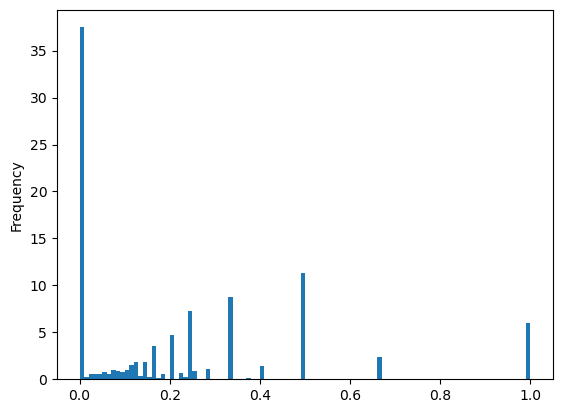

In [29]:
df_results_from_query_simple[df_results_from_query_simple["orcids"].apply(lambda x: len(eval(str(x))) > 0)]["ratio_author_orcid_in_open_ai"].plot.hist(bins=100, density=True)

In [30]:
df_results_from_query_simple["has_author_orcid_in_open_ai"] = df_results_from_query_simple["count_author_orcid_in_open_ai"].apply(lambda x: x > 0)

In [31]:
# [df_results_from_query_simple["orcids"].apply(lambda x: len(eval(str(x))) > 0)]
df_results_from_query_simple["has_author_orcid_in_open_ai"].mean()

0.5597897503285151

In [32]:
df_results_from_query_simple.iloc[[2]][["all_researchers", "all_names_oa"]]

,all_researchers,all_names_oa
2,"{nan, nan, Heitor Soares Ramos Filho, Alejandr...","[Ekler Paulino de Mattos, Augusto C. S. A. Dom..."


In [33]:
print(df_results_from_query_simple.iloc[[2]]["all_researchers"].values)

[{nan, nan, 'Heitor Soares Ramos Filho', 'Alejandro César Frery Orgambide - Amir Houmansadr - Antonio Alfredo Ferreira Loureiro - Fabricio Murai Ferreira - Leandro Aparecido Villas'}]


In [34]:
print(df_results_from_query_simple.iloc[[2]]["all_names_oa"].values)

[list(['Ekler Paulino de Mattos', 'Augusto C. S. A. Domingues', 'Fabrício A. Silva', 'Heitor S. Ramos', 'Antônio A. F. Loureiro'])]


In [35]:
df_results_from_query_simple

,project_id,orcids,title,summary,keywords,related_dois,pubs_names,name_doi_relationship,all_names_oa,all_orcids_oa,all_researchers,count_author_orcid_in_open_ai,ratio_author_orcid_in_open_ai,has_author_orcid_in_open_ai
0,23/00812-7,"[https://orcid.org/0000-0002-9144-7187, https:...",Aceleração de aplicações sensíveis a atrasos e...,Aplicações em nuvem são complexas e normalment...,"[Redes de computadores, Computação em nuvem, F...",[https://www.doi.org/10.1109/TNET.2023.3282562],[State Disaggregation for Dynamic Scaling of N...,{'State Disaggregation for Dynamic Scaling of ...,"[Fabrício Franco Carvalho, Ronaldo A. Ferreira...","[https://orcid.org/0000-0002-3481-4251, https:...","{nan, Italo Fernando Scotá Cunha, nan, Ronaldo...",2,0.500000,True
1,20/09835-1,"[http://orcid.org/0000-0002-4765-6459, http://...",IARA - Inteligência Artificial Recriando Ambie...,O Centro de Pesquisa Aplicada em Inteligência ...,"[Aprendizado computacional, Cidades inteligent...","[https://www.doi.org/10.1088/1741-2552/acf734,...",[Analysis of functional connectivity using mac...,{'Analysis of functional connectivity using ma...,"[Caroline L. Alves, Thaise G. L. de O. Toutain...","[https://orcid.org/0000-0003-4708-1330, https:...",{André Carlos Ponce de Leon Ferreira de Carval...,1,0.083333,True
2,23/00721-1,"[https://orcid.org/0000-0003-4523-6466, https:...",Quantificação de incerteza em aprendizado fede...,O projeto de pesquisa denominado Quantifying U...,"[Aprendizado federado, Redes bayesianas, Apren...",[https://www.doi.org/10.1016/j.comnet.2023.110...,[Slicing who slices: Anonymization quality eva...,{'Slicing who slices: Anonymization quality ev...,"[Ekler Paulino de Mattos, Augusto C. S. A. Dom...","[https://orcid.org/0000-0001-7020-1703, https:...","{nan, nan, Heitor Soares Ramos Filho, Alejandr...",1,0.200000,True
3,22/14503-3,"[https://orcid.org/0000-0002-2174-2762, https:...",Serviços de transporte inteligentes para as re...,"As futuras redes 6G são esperadas para 2030, q...","[Redes de computadores, Transmissão de dados, ...",[https://www.doi.org/10.1007/s11042-023-15301-4],[Towards augmented and mixed reality on future...,{'Towards augmented and mixed reality on futur...,"[Luís Fernando de Souza Cardoso, Bruno Yuji Li...","[https://orcid.org/0000-0003-4537-5183, https:...","{nan, nan, Bruno Yuji Lino Kimura, Toktam Mahm...",1,0.333333,True
4,23/00148-0,"[https://orcid.org/0000-0001-6994-8076, https:...",SocialNet: sensoriamento social para alavancar...,"Novas fontes massivas de dados, como o Waze e ...","[Computação urbana, Caracterização, Mineração ...",[https://www.doi.org/10.1007/s41109-023-00562-7],[On strategies to help reduce contamination on...,{'On strategies to help reduce contamination o...,"[Fernanda R. Gubert, Mauro Fonseca, Anelise Mu...","[https://orcid.org/0000-0003-3315-8026, https:...","{Thiago Henrique Silva, nan, nan, Daniel Silve...",1,0.250000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1517,96/07200-8,"[https://orcid.org/0000-0002-6022-0270, https:...","Abordagens iterativas em problemas inversos, c...",Serão abordadas três linhas de pesquisa conect...,"[Algoritmos, Algoritmos genéticos, Computação ...",[],[Inversão numérica de distribuições bidimensio...,{'Inversão numérica de distribuições bidimensi...,"[Fernando M. Ramos, Jonas C. Carvalho]","[https://orcid.org/0000-0001-5321-9805, https:...","{nan, nan, Pedro Paulo Balbi de Oliveira}",0,0.000000,False
1518,96/05497-3,"[https://orcid.org/0000-0001-5203-4366, https:...",Pesquisa em visão cibernética,O presente projeto visa suportar as atividades...,"[Inteligência artificial, Visão computacional,...",[],[Optimized approach to multiscale skeleton gen...,{'Optimized approach to multiscale skeleton ge...,"[Luciano da F. Costa, Maysa Santos Barbosa, Ri...","[https://orcid.org/0000-0001-5203-4366, https:...","{nan, Luciano da Fontoura Costa, nan}",1,0.142857,True
1519,96/04505-2,"[http://orcid.org/0000-0001-7841-157X, http://...",Aspectos estrutu

In [36]:
print(df_results_from_query_simple[df_results_from_query_simple["count_author_orcid_in_open_ai"] == 0].iloc[[10]][["all_names_oa", "all_researchers"]]["all_names_oa"].values)

[list(['Fabio Montoni', 'Willian Wang', 'Hugo A. Armelin', 'Marcelo S. Reis'])]


In [22]:
print(df_results_from_query_simple[df_results_from_query_simple["count_author_orcid_in_open_ai"] == 0].iloc[[10]][["all_names_oa", "all_researchers"]]["all_researchers"].values)

[{'Marcelo da Silva Reis', nan, 'Ronaldo Nogueira de Sousa', nan}]


In [29]:
# distribution of ratio of authors matching
# utilize first and last name strings for matching authors
# develop granular 

In [37]:
df_results_from_query_simple[["all_names_oa", "all_researchers"]]

,all_names_oa,all_researchers
0,"[Fabrício Franco Carvalho, Ronaldo A. Ferreira...","{nan, Italo Fernando Scotá Cunha, nan, Ronaldo..."
1,"[Caroline L. Alves, Thaise G. L. de O. Toutain...",{André Carlos Ponce de Leon Ferreira de Carval...
2,"[Ekler Paulino de Mattos, Augusto C. S. A. Dom...","{nan, nan, Heitor Soares Ramos Filho, Alejandr..."
3,"[Luís Fernando de Souza Cardoso, Bruno Yuji Li...","{nan, nan, Bruno Yuji Lino Kimura, Toktam Mahm..."
4,"[Fernanda R. Gubert, Mauro Fonseca, Anelise Mu...","{Thiago Henrique Silva, nan, nan, Daniel Silve..."
...,...,...
1517,"[Fernando M. Ramos, Jonas C. Carvalho]","{nan, nan, Pedro Paulo Balbi de Oliveira}"
1518,"[Luciano da F. Costa, Maysa Santos Barbosa, Ri...","{nan, Luciano da Fontoura Costa, nan}"
1519,"[Yoshiharu Kohayakawa, Hein van der Holst, Jos...","{nan, Yoshiharu Kohayakawa, nan}"
1520,[Regina Célia Coelho],"{nan, nan, Luciano da Fontoura Costa}"


In [40]:
import numpy as np
from numpy import nan

In [51]:
match_ratio_per_name = []
matched_names = []
for _, row in df_results_from_query_simple[["all_names_oa", "all_researchers"]].iterrows():
    all_names_oa_eval = list(set(eval(str(row["all_names_oa"]))))
    all_researchers_eval = list(set(list(eval(str(row["all_researchers"])))))
    all_researchers_eval.remove(np.nan)
    l = len(all_names_oa_eval)
    if l == 0:
        match_ratio_per_name.append(np.nan)
        matched_names.append([])
        continue
    matched_names_curr = []
    count = 0
    for n1 in all_names_oa_eval:
        n1 = n1.split(" ")
        for n2 in all_researchers_eval:
            n2 = n2.split(" ")
            if n1[0] == n2[0] and n1[-1] == n2[-1]:
                count += 1
                matched_names_curr.append(" ".join(n1))
    match_ratio_per_name.append(count / l)
    matched_names.append(matched_names_curr)


In [ ]:
# df_results_from_query_simple[df_results_from_query_simple["orcids"].apply(lambda x: len(eval(str(x))) > 0)]["ratio_author_orcid_in_open_ai"].plot.hist(bins=100, density=True)

In [55]:
df_results_from_query_simple = df_results_from_query_simple.assign(ratio_author_name_in_open_alex=match_ratio_per_name, matched_names=matched_names)

<Axes: ylabel='Frequency'>

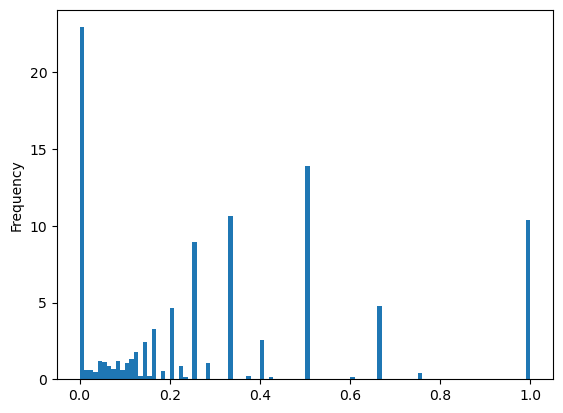

In [57]:
df_results_from_query_simple["ratio_author_name_in_open_alex"].plot.hist(bins=100, density=True)

In [67]:
df_results_from_query_simple["ratio_author_name_in_open_alex"].mean()

0.3125785115052758

In [68]:
df_results_from_query_simple["has_author_orcid_in_open_ai"].mean()

0.5597897503285151

In [59]:
df_results_from_query_simple["ratio_author_name_in_open_alex"].apply(lambda x: x > 0).mean()

0.6655716162943496

In [60]:
df_results_from_query_simple[~df_results_from_query_simple["has_author_orcid_in_open_ai"]]["ratio_author_name_in_open_alex"].apply(lambda x: x > 0).mean()

0.4582089552238806

In [61]:
df_results_from_query_simple["has_author_name_in_open_ai"] = df_results_from_query_simple["ratio_author_name_in_open_alex"].apply(lambda x: x > 0)

In [63]:
df_results_from_query_simple

,project_id,orcids,title,summary,keywords,related_dois,pubs_names,name_doi_relationship,all_names_oa,all_orcids_oa,all_researchers,count_author_orcid_in_open_ai,ratio_author_orcid_in_open_ai,has_author_orcid_in_open_ai,ratio_author_name_in_open_alex,matched_names,has_author_name_in_open_ai
0,23/00812-7,"[https://orcid.org/0000-0002-9144-7187, https:...",Aceleração de aplicações sensíveis a atrasos e...,Aplicações em nuvem são complexas e normalment...,"[Redes de computadores, Computação em nuvem, F...",[https://www.doi.org/10.1109/TNET.2023.3282562],[State Disaggregation for Dynamic Scaling of N...,{'State Disaggregation for Dynamic Scaling of ...,"[Fabrício Franco Carvalho, Ronaldo A. Ferreira...","[https://orcid.org/0000-0002-3481-4251, https:...","{nan, Italo Fernando Scotá Cunha, nan, Ronaldo...",2,0.500000,True,0.250000,[Ronaldo A. Ferreira],True
1,20/09835-1,"[http://orcid.org/0000-0002-4765-6459, http://...",IARA - Inteligência Artificial Recriando Ambie...,O Centro de Pesquisa Aplicada em Inteligência ...,"[Aprendizado computacional, Cidades inteligent...","[https://www.doi.org/10.1088/1741-2552/acf734,...",[Analysis of functional connectivity using mac...,{'Analysis of functional connectivity using ma...,"[Caroline L. Alves, Thaise G. L. de O. Toutain...","[https://orcid.org/0000-0003-4708-1330, https:...",{André Carlos Ponce de Leon Ferreira de Carval...,1,0.083333,True,0.083333,[André C. P. L. F. de Carvalho],True
2,23/00721-1,"[https://orcid.org/0000-0003-4523-6466, https:...",Quantificação de incerteza em aprendizado fede...,O projeto de pesquisa denominado Quantifying U...,"[Aprendizado federado, Redes bayesianas, Apren...",[https://www.doi.org/10.1016/j.comnet.2023.110...,[Slicing who slices: Anonymization quality eva...,{'Slicing who slices: Anonymization quality ev...,"[Ekler Paulino de Mattos, Augusto C. S. A. Dom...","[https://orcid.org/0000-0001-7020-1703, https:...","{nan, nan, Heitor Soares Ramos Filho, Alejandr...",1,0.200000,True,0.000000,[],False
3,22/14503-3,"[https://orcid.org/0000-0002-2174-2762, https:...",Serviços de transporte inteligentes para as re...,"As futuras redes 6G são esperadas para 2030, q...","[Redes de computadores, Transmissão de dados, ...",[https://www.doi.org/10.1007/s11042-023-15301-4],[Towards augmented and mixed reality on future...,{'Towards augmented and mixed reality on futur...,"[Luís Fernando de Souza Cardoso, Bruno Yuji Li...","[https://orcid.org/0000-0003-4537-5183, https:...","{nan, nan, Bruno Yuji Lino Kimura, Toktam Mahm...",1,0.333333,True,0.333333,[Bruno Yuji Lino Kimura],True
4,23/00148-0,"[https://orcid.org/0000-0001-6994-8076, https:...",SocialNet: sensoriamento social para alavancar...,"Novas fontes massivas de dados, como o Waze e ...","[Computação urbana, Caracterização, Mineração ...",[https://www.doi.org/10.1007/s41109-023-00562-7],[On strategies to help reduce contamination on...,{'On strategies to help reduce contamination o...,"[Fernanda R. Gubert, Mauro Fonseca, Anelise Mu...","[https://orcid.org/0000-0003-3315-8026, https:...","{Thiago Henrique Silva, nan, nan, Daniel Silve...",1,0.250000,True,0.250000,[Thiago H. Silva],True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1517,96/07200-8,"[https://orcid.org/0000-0002-6022-0270, https:...","Abordagens iterativas em problemas inversos, c...",Serão abordadas três linhas de pesquisa conect...,"[Algoritmos, Algoritmos genéticos, Computação ...",[],[Inversão numérica de distribuições bidimensio...,{'Inversão numérica de distribuições bidimensi...,"[Fernando M. Ramos, Jonas C. Carvalho]","[https://orcid.org/0000-0001-5321-9805, https:...","{nan, nan, Pedro Paulo Balbi de Oliveira}",0,0.000000,False,0.000000,[],False
1518,96/05497-3,"[https://orcid.org/0000-0001-5203-4366, https:...",Pesquisa em visão cibernética,O presente projeto visa suportar as atividades...,"[Inteligência artificial, Visão computacional,...",[],[Optimized approach to multiscale skeleton gen...,{'Optimized approach 

In [65]:
len(df_results_from_query_simple[df_results_from_query_simple["has_author_orcid_in_open_ai"]]) / len(df_results_from_query_simple)

0.5597897503285151

In [66]:
len(df_results_from_query_simple[df_results_from_query_simple["has_author_name_in_open_ai"]]) / len(df_results_from_query_simple)

0.6655716162943496

In [64]:
len(df_results_from_query_simple[df_results_from_query_simple["has_author_name_in_open_ai"] | df_results_from_query_simple["has_author_orcid_in_open_ai"]]) / len(df_results_from_query_simple)

0.7614980289093298

# TODO:
* Compute ratio: (all authors present in open alex / all authors in projects)
* Sample projects without matching and analyze the divergence between papers match and authors match
* add memory to scraping script (save each page results in a pickle)
* `df_results_from_query_simple["count_author_orcid_in_open_ai"].sum() / df_results_from_query_simple.apply(lambda x: len(set(x["all_orcids_oa"])) ,axis=1).sum()` for orcid + name matching 

In [56]:
df_results_from_query_simple

,project_id,orcids,title,summary,keywords,related_dois,pubs_names,name_doi_relationship,all_names_oa,all_orcids_oa,all_researchers,count_author_orcid_in_open_ai,ratio_author_orcid_in_open_ai,has_author_orcid_in_open_ai,ratio_author_name_in_open_alex,matched_names
0,23/00812-7,"[https://orcid.org/0000-0002-9144-7187, https:...",Aceleração de aplicações sensíveis a atrasos e...,Aplicações em nuvem são complexas e normalment...,"[Redes de computadores, Computação em nuvem, F...",[https://www.doi.org/10.1109/TNET.2023.3282562],[State Disaggregation for Dynamic Scaling of N...,{'State Disaggregation for Dynamic Scaling of ...,"[Fabrício Franco Carvalho, Ronaldo A. Ferreira...","[https://orcid.org/0000-0002-3481-4251, https:...","{nan, Italo Fernando Scotá Cunha, nan, Ronaldo...",2,0.500000,True,0.250000,[Ronaldo A. Ferreira]
1,20/09835-1,"[http://orcid.org/0000-0002-4765-6459, http://...",IARA - Inteligência Artificial Recriando Ambie...,O Centro de Pesquisa Aplicada em Inteligência ...,"[Aprendizado computacional, Cidades inteligent...","[https://www.doi.org/10.1088/1741-2552/acf734,...",[Analysis of functional connectivity using mac...,{'Analysis of functional connectivity using ma...,"[Caroline L. Alves, Thaise G. L. de O. Toutain...","[https://orcid.org/0000-0003-4708-1330, https:...",{André Carlos Ponce de Leon Ferreira de Carval...,1,0.083333,True,0.083333,[André C. P. L. F. de Carvalho]
2,23/00721-1,"[https://orcid.org/0000-0003-4523-6466, https:...",Quantificação de incerteza em aprendizado fede...,O projeto de pesquisa denominado Quantifying U...,"[Aprendizado federado, Redes bayesianas, Apren...",[https://www.doi.org/10.1016/j.comnet.2023.110...,[Slicing who slices: Anonymization quality eva...,{'Slicing who slices: Anonymization quality ev...,"[Ekler Paulino de Mattos, Augusto C. S. A. Dom...","[https://orcid.org/0000-0001-7020-1703, https:...","{nan, nan, Heitor Soares Ramos Filho, Alejandr...",1,0.200000,True,0.000000,[]
3,22/14503-3,"[https://orcid.org/0000-0002-2174-2762, https:...",Serviços de transporte inteligentes para as re...,"As futuras redes 6G são esperadas para 2030, q...","[Redes de computadores, Transmissão de dados, ...",[https://www.doi.org/10.1007/s11042-023-15301-4],[Towards augmented and mixed reality on future...,{'Towards augmented and mixed reality on futur...,"[Luís Fernando de Souza Cardoso, Bruno Yuji Li...","[https://orcid.org/0000-0003-4537-5183, https:...","{nan, nan, Bruno Yuji Lino Kimura, Toktam Mahm...",1,0.333333,True,0.333333,[Bruno Yuji Lino Kimura]
4,23/00148-0,"[https://orcid.org/0000-0001-6994-8076, https:...",SocialNet: sensoriamento social para alavancar...,"Novas fontes massivas de dados, como o Waze e ...","[Computação urbana, Caracterização, Mineração ...",[https://www.doi.org/10.1007/s41109-023-00562-7],[On strategies to help reduce contamination on...,{'On strategies to help reduce contamination o...,"[Fernanda R. Gubert, Mauro Fonseca, Anelise Mu...","[https://orcid.org/0000-0003-3315-8026, https:...","{Thiago Henrique Silva, nan, nan, Daniel Silve...",1,0.250000,True,0.250000,[Thiago H. Silva]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1517,96/07200-8,"[https://orcid.org/0000-0002-6022-0270, https:...","Abordagens iterativas em problemas inversos, c...",Serão abordadas três linhas de pesquisa conect...,"[Algoritmos, Algoritmos genéticos, Computação ...",[],[Inversão numérica de distribuições bidimensio...,{'Inversão numérica de distribuições bidimensi...,"[Fernando M. Ramos, Jonas C. Carvalho]","[https://orcid.org/0000-0001-5321-9805, https:...","{nan, nan, Pedro Paulo Balbi de Oliveira}",0,0.000000,False,0.000000,[]
1518,96/05497-3,"[https://orcid.org/0000-0001-5203-4366, https:...",Pesquisa em visão cibernética,O presente projeto visa suportar as atividades...,"[Inteligência artificial, Visão computacional,...",[],[Optimized approach to multiscale skeleton gen...,{'Optimized approach to multiscale skeleton ge...,"[Luciano da F. Costa, Maysa Santo

In [27]:
df_results_from_query_simple[df_results_from_query_simple["count_author_orcid_in_open_ai"] == 0].iloc[[10]]

,project_id,orcids,title,summary,keywords,related_dois,pubs_names,name_doi_relationship,all_names_oa,all_orcids_oa,all_researchers,count_author_orcid_in_open_ai,has_author_orcid_in_open_ai
62,19/24580-2,"[http://orcid.org/0000-0002-3754-9115, https:/...",Seleção bayesiana de modelos dinâmicos de vias...,Uma via de sinalização celular é composta por ...,"[Biologia computacional, Inferência bayesiana,...",[https://www.doi.org/10.1109/eScience55777.202...,[Anguix: Cell Signaling Modeling Improvement t...,{'Anguix: Cell Signaling Modeling Improvement ...,"[Fabio Montoni, Willian Wang, Hugo A. Armelin,...","[https://orcid.org/0000-0002-9266-1281, https:...","{Marcelo da Silva Reis, nan, Ronaldo Nogueira ...",0,False


In [14]:
Authors()["https://orcid.org/0000-0002-5591-3750"]

{'id': 'https://openalex.org/A5023928945',
 'orcid': 'https://orcid.org/0000-0002-5591-3750',
 'display_name': 'Jó Ueyama',
 'display_name_alternatives': ['Jó Ueyama',
  'Jo Ueyama',
  'UeyamaJo',
  'J. Ueyama'],
 'works_count': 160,
 'cited_by_count': 2365,
 'summary_stats': {'2yr_mean_citedness': 3.6666666666666665,
  'h_index': 24,
  'i10_index': 48},
 'ids': {'openalex': 'https://openalex.org/A5023928945',
  'orcid': 'https://orcid.org/0000-0002-5591-3750'},
 'affiliations': [{'institution': {'id': 'https://openalex.org/I17974374',
    'ror': 'https://ror.org/036rp1748',
    'display_name': 'Universidade de São Paulo',
    'country_code': 'BR',
    'type': 'education',
    'lineage': ['https://openalex.org/I17974374']},
   'years': [2024, 2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015]},
  {'institution': {'id': 'https://openalex.org/I4210131883',
    'ror': 'https://ror.org/03kcw4w74',
    'display_name': 'Brazilian Society of Computational and Applied Mathematics',
    'cou